# Exploratory notebook on LDA on the considered dialogue data sets

In this notebook we test *Latent Dirichlet Allocation* ([LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)) with different components to find the most suitable dimension to train the DLDLM model.

The code is adapted from a [Scikit-Learn tutorial](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

## Imports

Import required packages

In [1]:
%matplotlib inline

import os

from math import ceil
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from data import DataSetSplit
from data.corpora import DailyDialog, EmpatheticDialogues, Hope, PersonaChat, WizardOfWikipedia
from model import DLDLMTokenizer

from typing import Optional, List, Dict

/home/vincenzo/anaconda3/envs/dldlm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vincenzo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vincenzo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Constants

Here we define the constants like paths, number of latent codes, number of top words to visualise, etc.

Paths

In [5]:
data_dir_path: str = '../resources/data/raw/'
visual_dir_path: str = '../resources/visualisation/'
if not os.path.exists(visual_dir_path):
    os.mkdir(visual_dir_path)

Data loading

In [6]:
pre_training_corpora_mapping: Dict = {
    DailyDialog.IDENTIFIER: DailyDialog,
    EmpatheticDialogues.IDENTIFIER: EmpatheticDialogues,
    Hope.IDENTIFIER: Hope,
    PersonaChat.IDENTIFIER: PersonaChat,
    WizardOfWikipedia.IDENTIFIER: WizardOfWikipedia,
}
target_corpora_mapping: Dict = {
    Hope.IDENTIFIER: Hope,
}

tokeniser = DLDLMTokenizer.from_pretrained('gpt2')
splits = [DataSetSplit.TRAIN, DataSetSplit.VALIDATION, DataSetSplit.TEST]

max_context_length: int = 256

parallel_backend: str = 'threading'
n_jobs: int = -1
verbosity_level: int = 0

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'DLDLMTokenizer'.


LDA

In [37]:
random_seed: Optional[int] = 2307

n_configs: int = 6
n_latents = [2 ** (i + 1) for i in range(n_configs)]
n_iters = 10
learning_offset = 50.0

Visualisation

In [36]:
n_top_words = 20
figure_counter = 0

## Helper functions

Here we define some helper functions to ease the process

### Visualisation

Functions for data visualisation

Plot the most common words for each topic according to the LDA output.
This will help understand if the latent groupings show some sort of consistency (within and between).

In [31]:
def plot_top_words(
        model: LatentDirichletAllocation,
        feature_names: np.ndarray,
        n_top_words: int,
        title: str,
        save_figure: bool = True,
        show_figure: bool = False
):
    global figure_counter
    fig, axes = plt.subplots(int(ceil(model.n_components / 4)), 4, figsize=(24, 2 + (6 * int(ceil(model.n_components / 4)))), sharex=True)
    axes = axes.flatten()
    for latent_idx, latent in enumerate(model.components_):
        top_features_ind = latent.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = latent[top_features_ind]
        ax = axes[latent_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Latent {latent_idx + 1}", fontdict={"fontsize": 24})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=16)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(wspace=0.90, hspace=0.3)
    # plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

    if save_figure:
        plt.savefig(os.path.join(visual_dir_path, f"{str(figure_counter).zfill(3)}.pdf"), pad_inches=0)
        figure_counter += 1
    if show_figure:
        plt.show()

Plot the distribution .
This will help understand if the latent groupings show some sort of consistency (within and between).

In [33]:
def plot_latent_dist(
        model: LatentDirichletAllocation,
        data: Dict[DataSetSplit, np.ndarray],
        title: str,
        save_figure: bool = True,
        show_figure: bool = False
):
    global figure_counter
    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)
    axes = axes.flatten()
    for split_idx, (split, X) in enumerate(data.items()):
        p_dist = model.transform(X)
        avg = p_dist.mean(0)
        std = p_dist.std(0)
        ax = axes[split_idx]
        ax.bar(range(model.n_components), avg, yerr=std)
        ax.set_title(f"{split.value.capitalize()} set", fontdict={"fontsize": 24})
        ax.tick_params(axis="y", which="major", labelsize=16)
        ax.set_ylim(bottom=0.0, top=1.0)
        plt.xticks([])
    fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.80, bottom=0.05, wspace=(16 / model.n_components) * 0.9, hspace=0.3)

    if save_figure:
        plt.savefig(os.path.join(visual_dir_path, f"{str(figure_counter).zfill(3)}.pdf"), pad_inches=0)
        figure_counter += 1
    if show_figure:
        plt.show()

## Main code

Main code of the notebook with data loading, preparation and results visualisation.

### Data loading

We load the five considered data sets:
- [DailyDialog](https://www.aclweb.org/anthology/I17-1099/) (DD)
- [EmpatheticDialogues](https://www.aclweb.org/anthology/P19-1534/) (ED)
- [HOPE Dataset](https://dl.acm.org/doi/10.1145/3488560.3498509) (HOPE)
- [Persona-Chat](https://aclanthology.org/P18-1205/) (PC)
- [Wizard of Wikipedia](https://arxiv.org/abs/1811.01241) (WoW)

We merge together DD, ED, PC and WoW since they compose the pre-training data sets we use to learn the latent model.
Then we apply the results to HOPE.

As for now we limit the analysis to the training splits of all the models.

#### Pre-training data sets

Load corpora

In [11]:
pretraining_data_sets: Dict[DataSetSplit, List] = {
    split: [
        data_set(
            os.path.join(data_dir_path, id),
            split,
            tokeniser,
            max_context_length=max_context_length,
            parallel_backend=parallel_backend,
            n_jobs=n_jobs,
            verbosity_level=verbosity_level
        )
        for id, data_set in pre_training_corpora_mapping.items()
    ]
    for split in splits
}

Gather all response utterance strings to form the document collection

In [12]:
pretraining_documents: Dict[DataSetSplit, List[str]] = {
        split: [data_set[i]['response'] for data_set in pretraining_data_sets[split] for i in range(len(data_set))]
        for split in pretraining_data_sets
}

#### Target data set

Load corpora

In [13]:
target_data_sets: Dict[DataSetSplit, List] = {
    split: [
        data_set(
            os.path.join(data_dir_path, id),
            split,
            tokeniser,
            max_context_length=max_context_length,
            parallel_backend=parallel_backend,
            n_jobs=n_jobs,
            verbosity_level=verbosity_level
        )
        for id, data_set in target_corpora_mapping.items()
    ]
    for split in splits
}

Gather all response utterance strings to form the document collection

In [14]:
target_documents: Dict[DataSetSplit, List[str]] = {
        split: [data_set[i]['response'] for data_set in target_data_sets[split] for i in range(len(data_set))]
        for split in target_data_sets
}

### Vectorisation

We consider both *Term Frequency* ([TF]()) and *Term Frequency-Inverse Document Frequency* ([TF-IDF]()) vectorisations

#### TF

We learn a TF vectorisation model on the four pre-training data sets using their training split.
We ignore corpus specific stop-words with a document frequency above 95% and we ignore rare word that occur less than 2 times in the corpus.
This model will be used to feed the LDA model.

Fit model

In [15]:
tf_vectoriser = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
tf_vectoriser.fit(pretraining_documents[DataSetSplit('train')])

CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

Get the identified word types

In [16]:
tf_feature_names = tf_vectoriser.get_feature_names_out()

Apply vectorisation

In [17]:
X_source = {split: tf_vectoriser.transform(pretraining_documents[split]) for split in splits}
X_target = {split: tf_vectoriser.transform(target_documents[split]) for split in splits}

#### TF-IDF

We learn a TF-IDF vectorisation model on the four pre-training data sets using their training split.
We ignore corpus specific stop-words with a document frequency above 95% and we ignore rare word that occur less than 2 times in the corpus.
This model will be used for visualisation.

In [ ]:
tfidf_vectoriser = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")
tfidf_vectoriser.fit(pretraining_documents)

### LDA

Finally, we can apply LDA and gather the results.
It is possible to do it either exploring directly multiple approaches or manually setting the parameters

#### Explorative LDA

Run LDA saving the results at each step on the pre-training corpus and the target corpus.

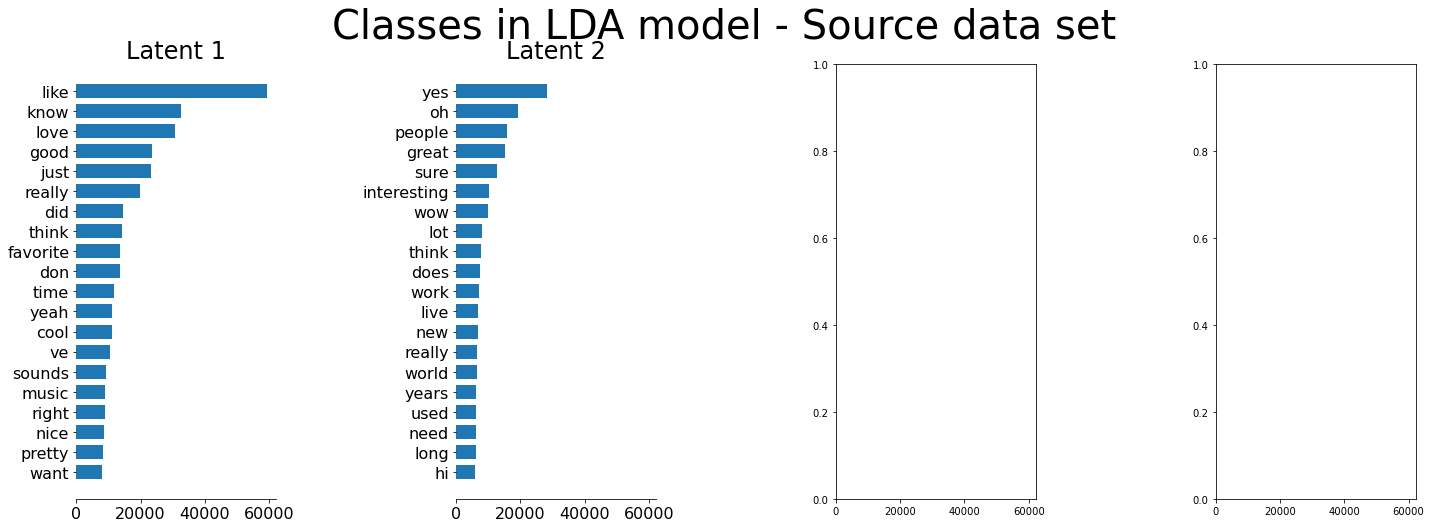

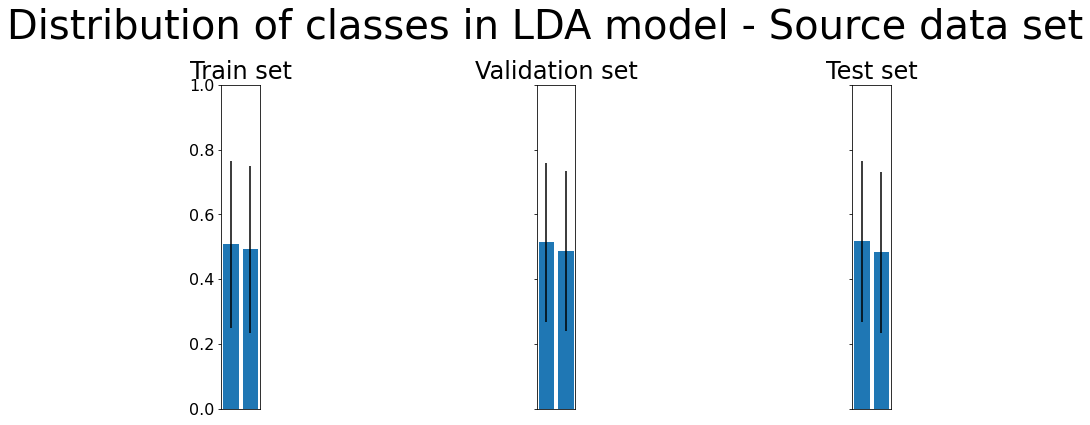

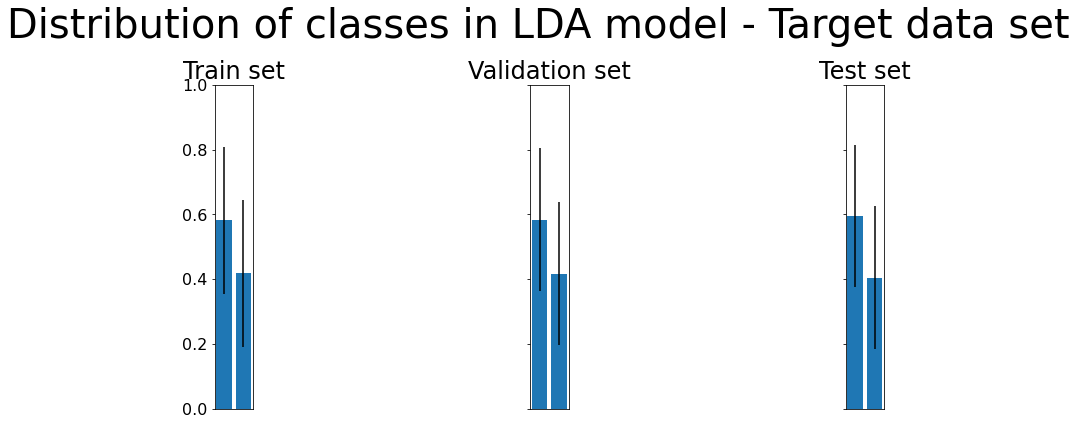

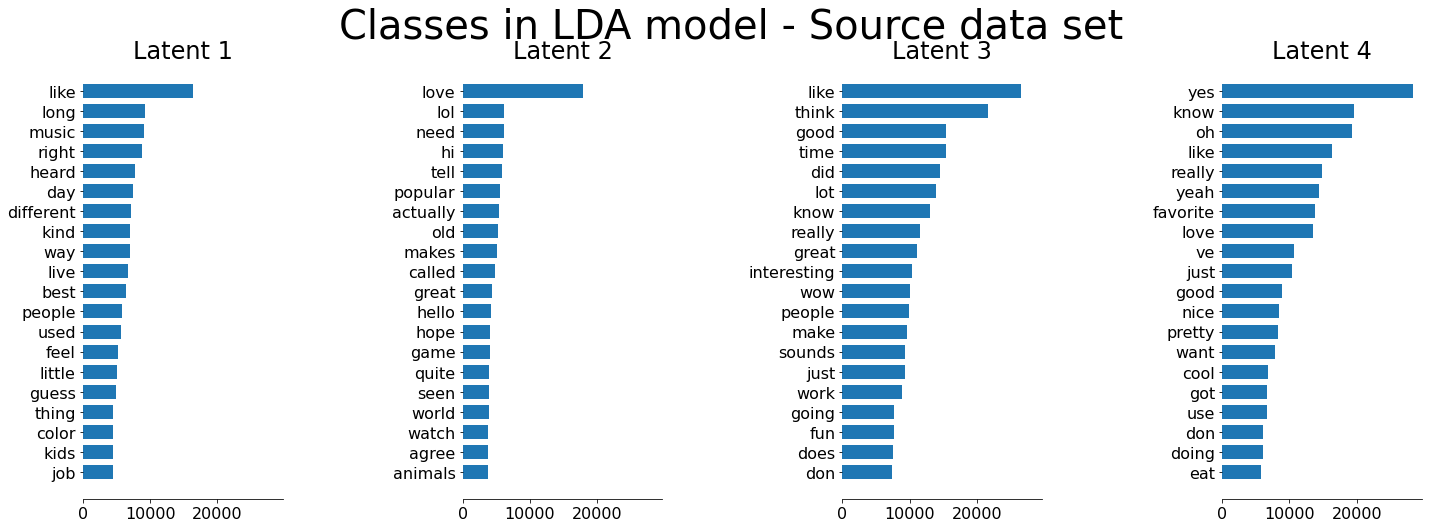

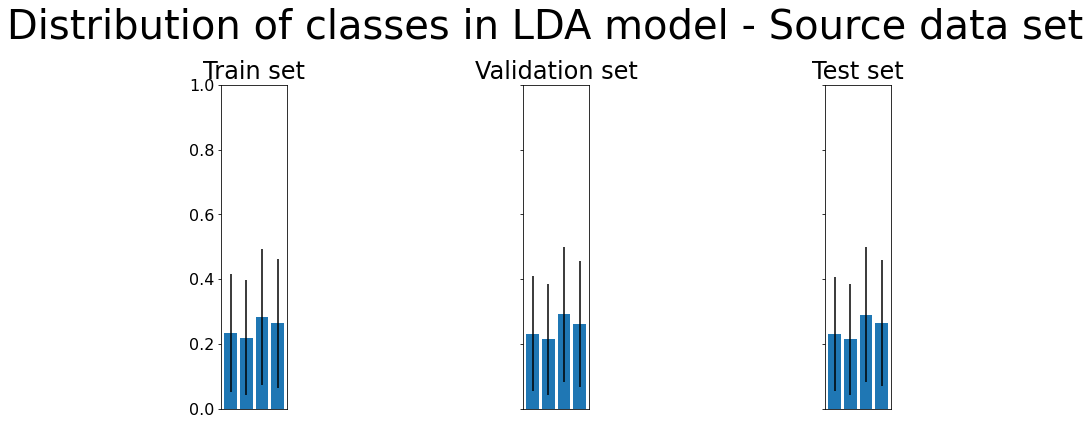

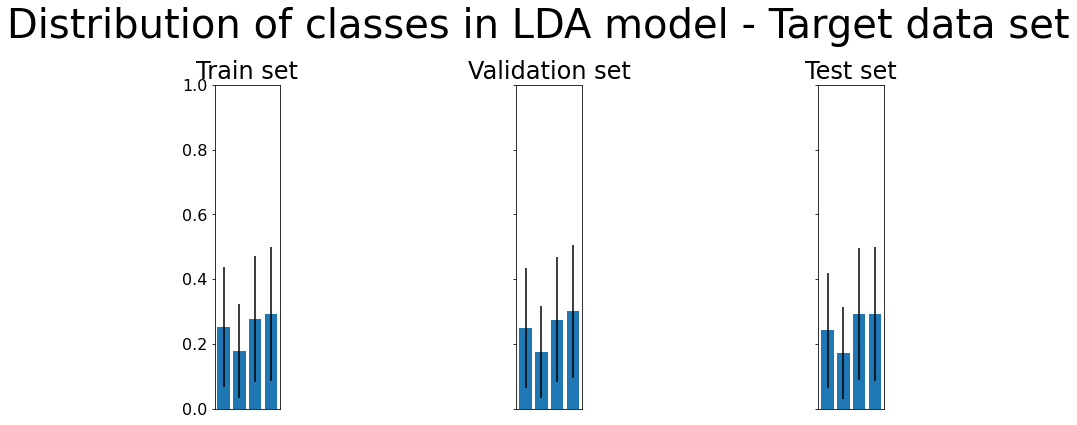

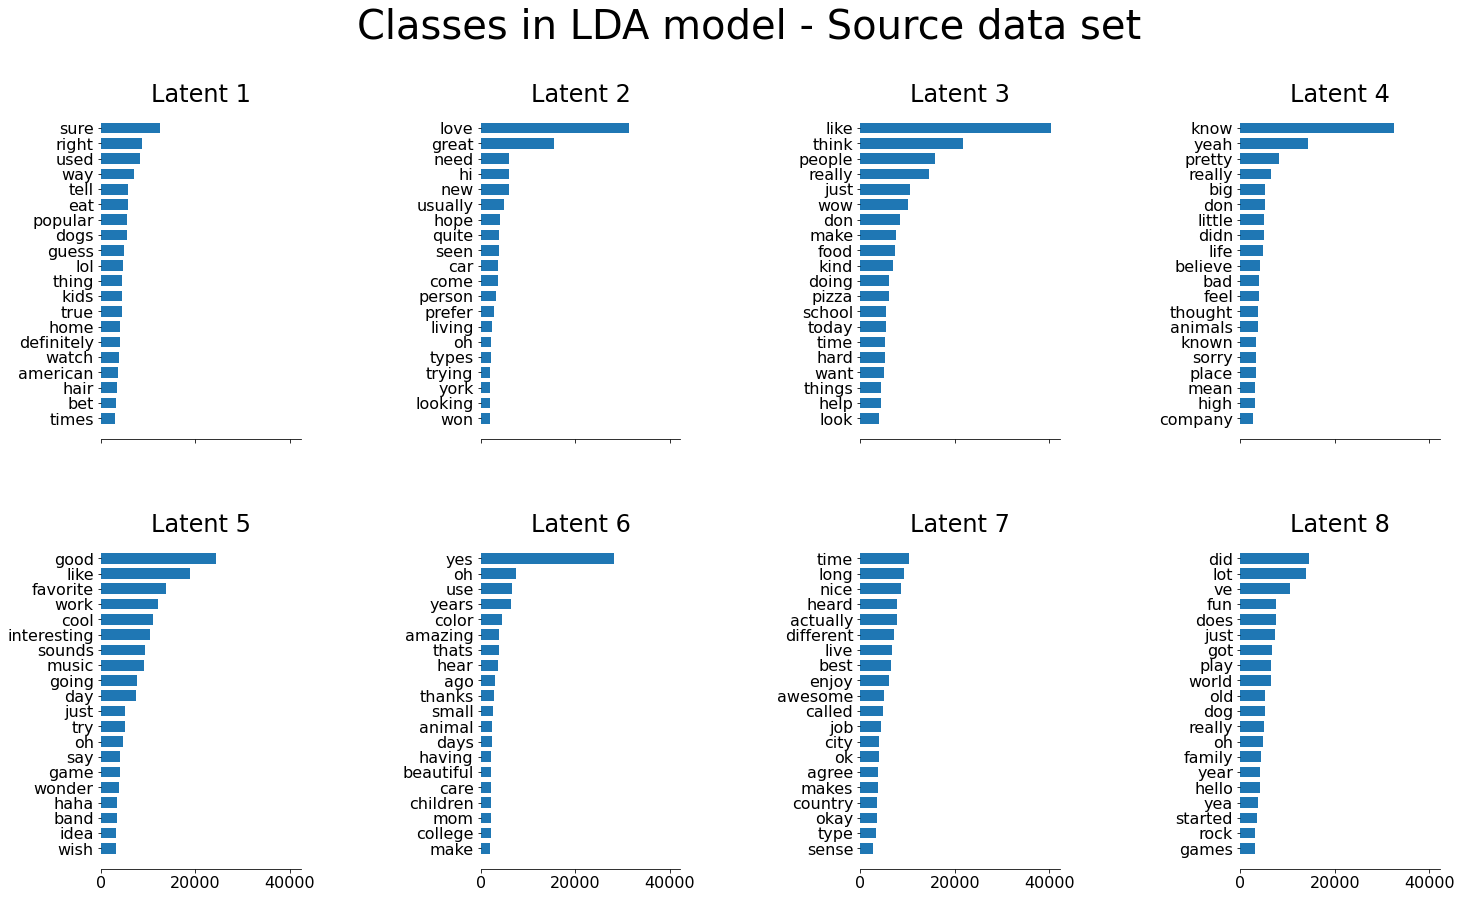

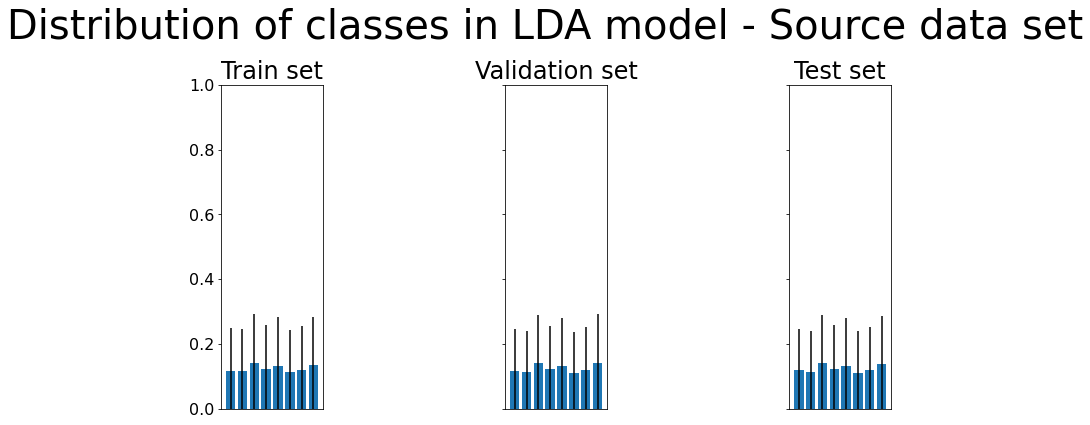

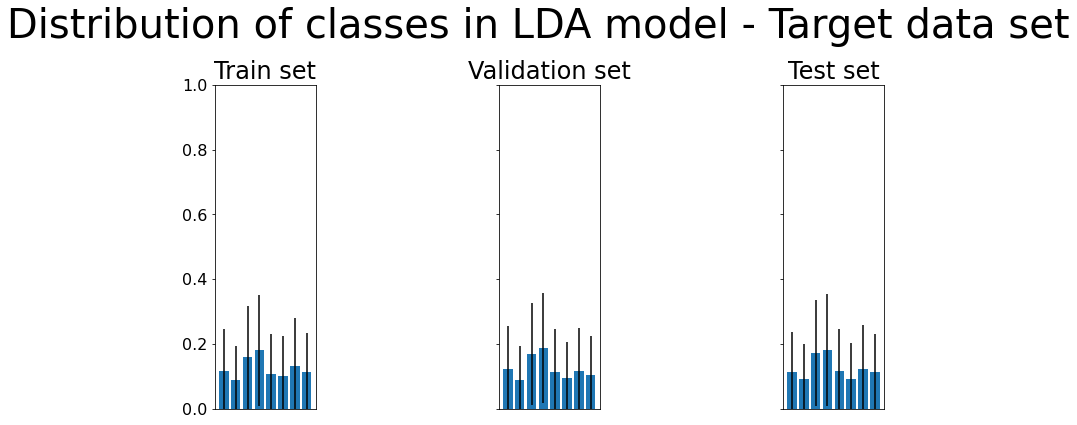

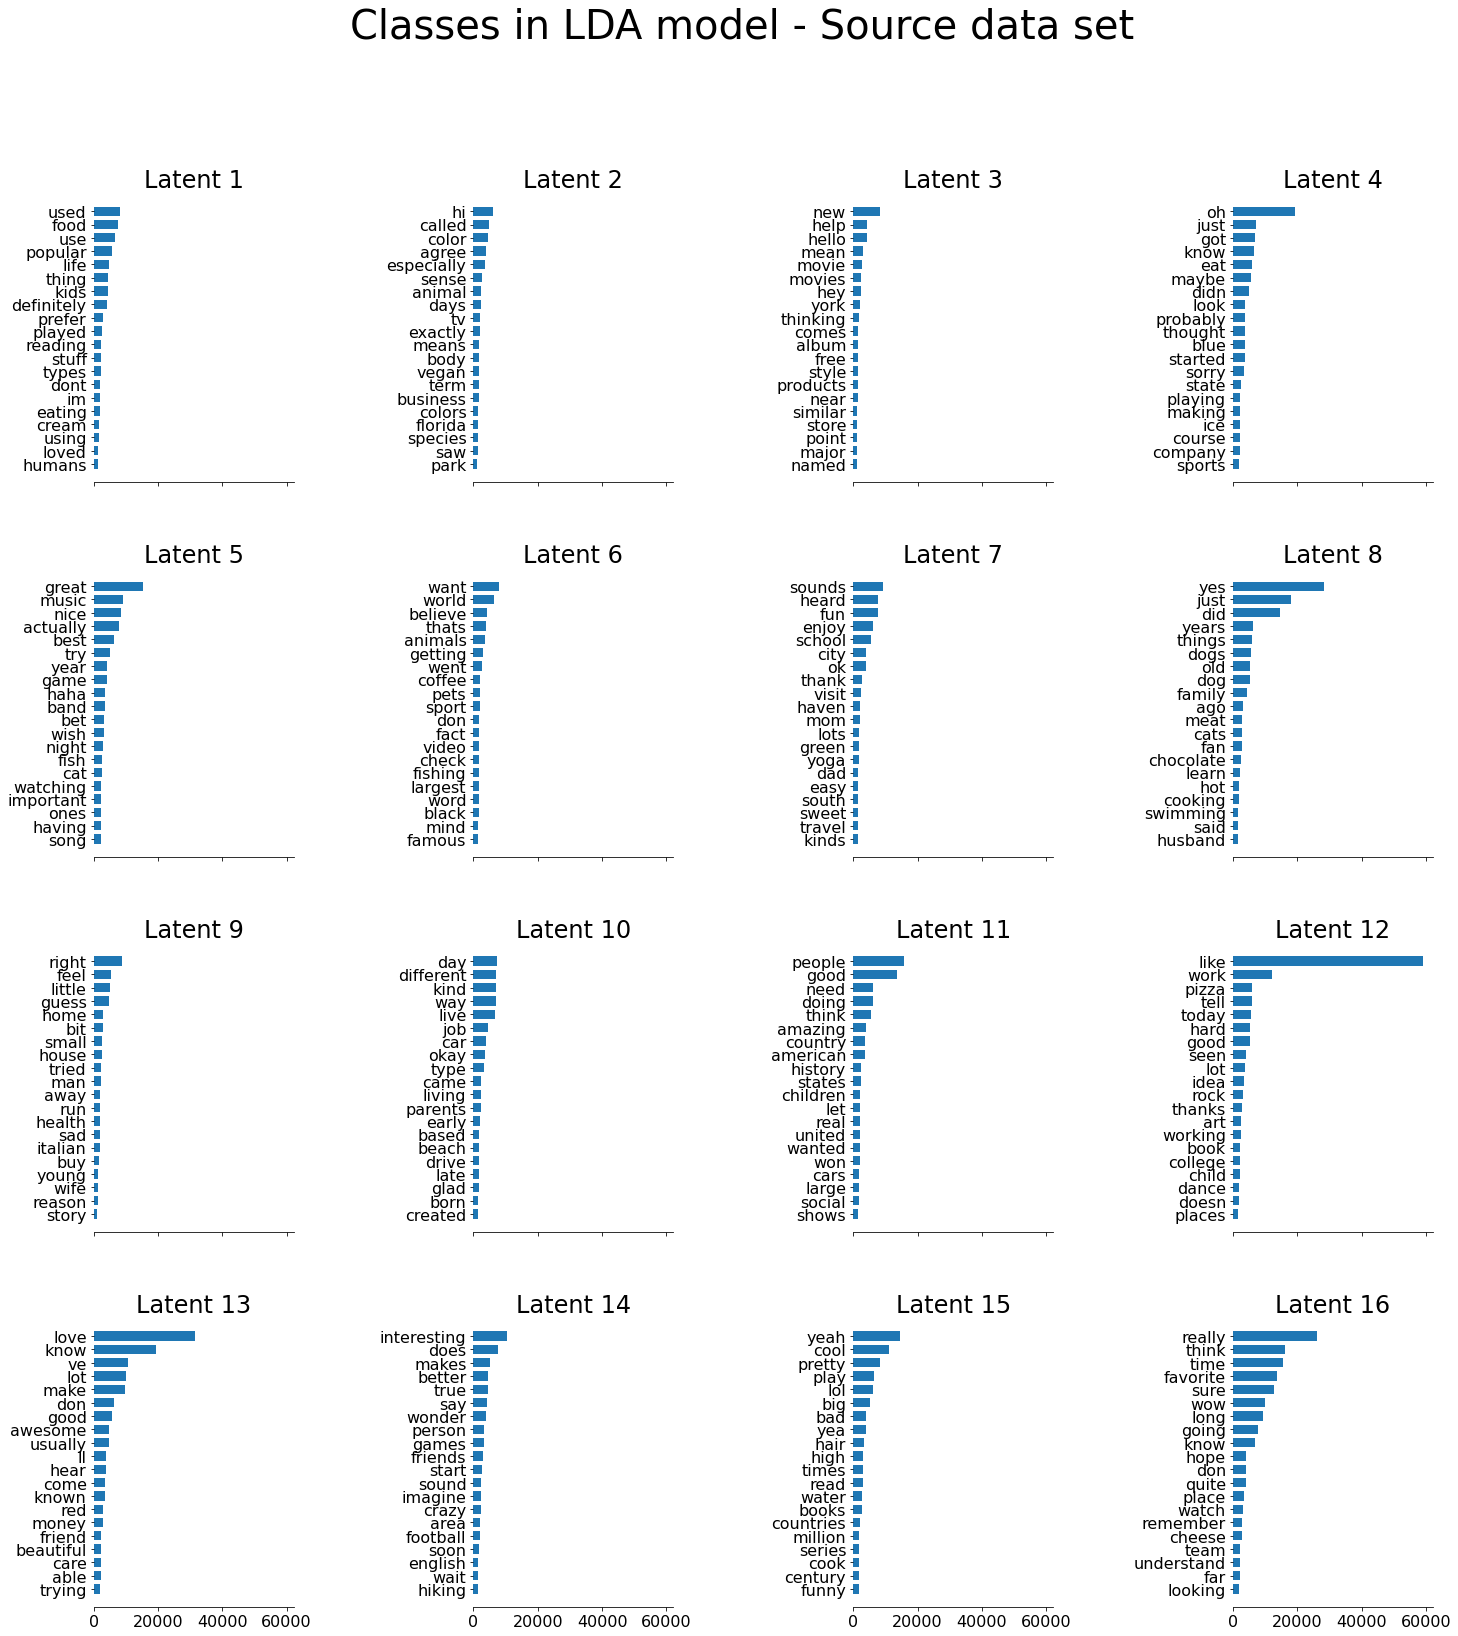

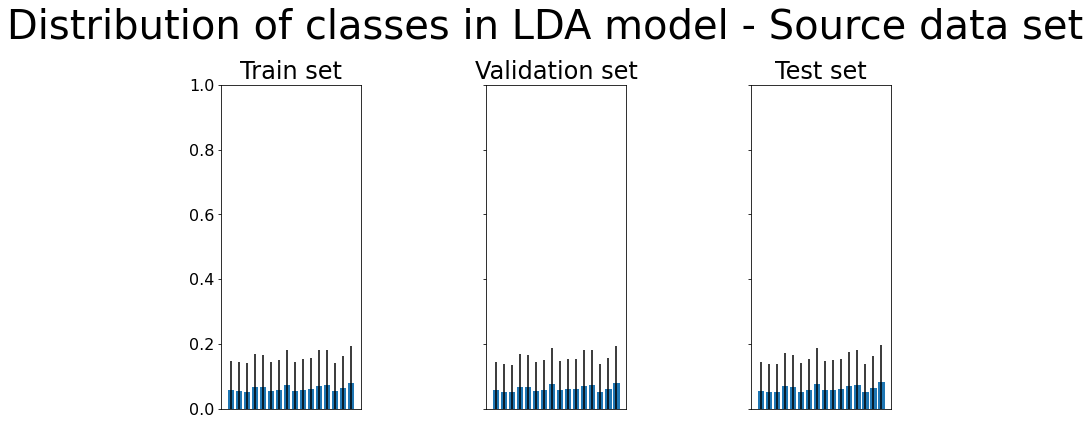

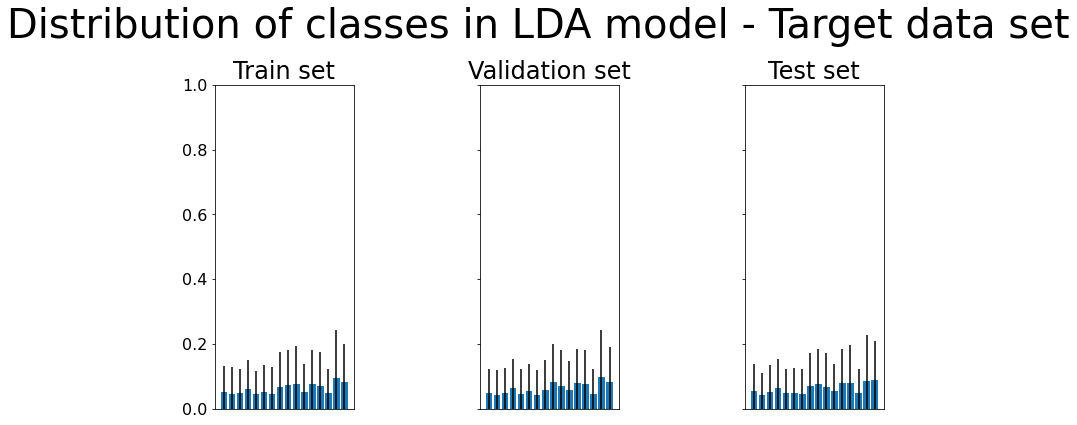

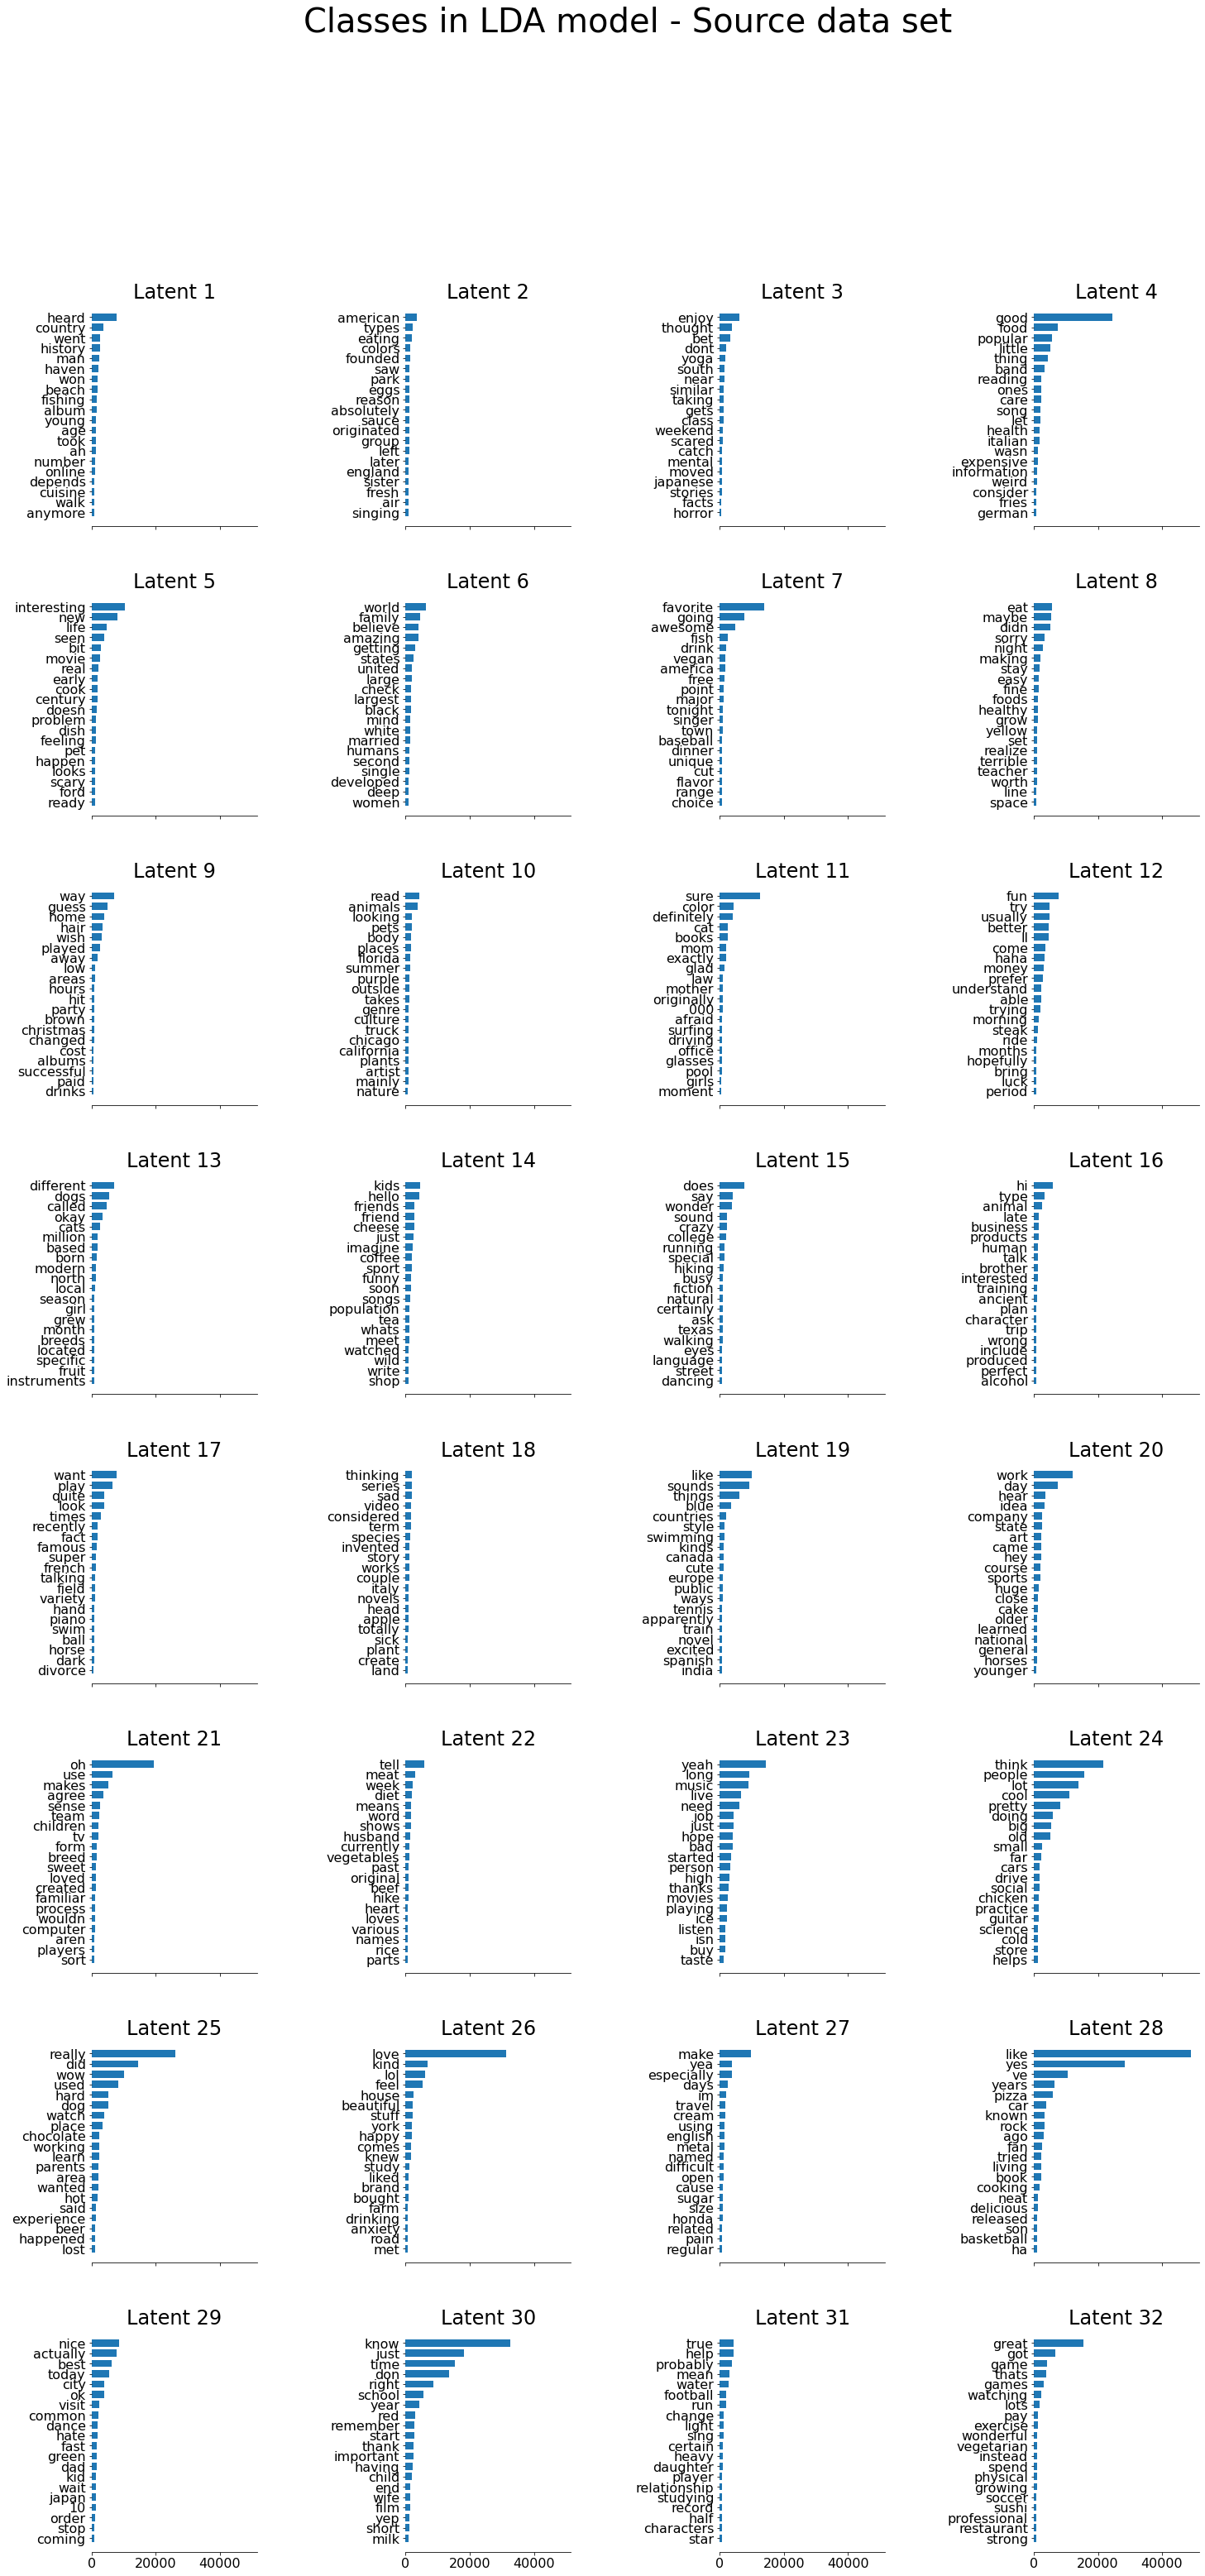

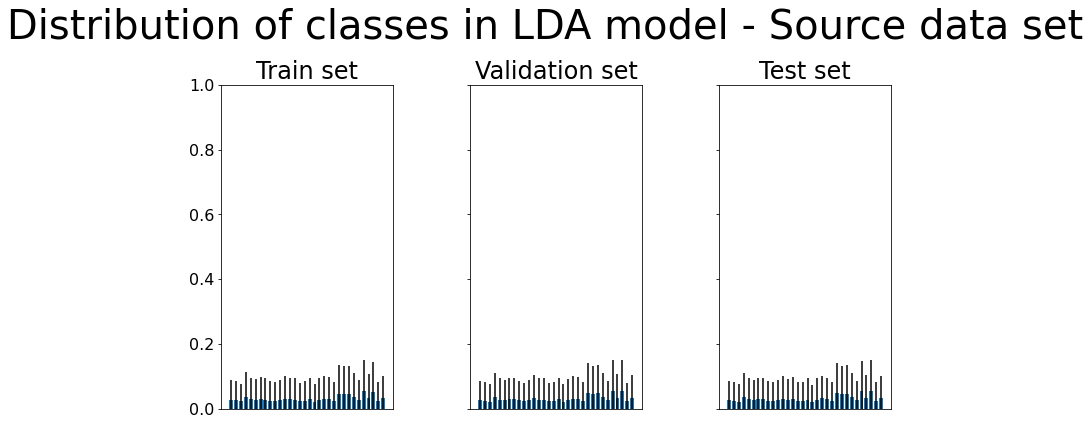

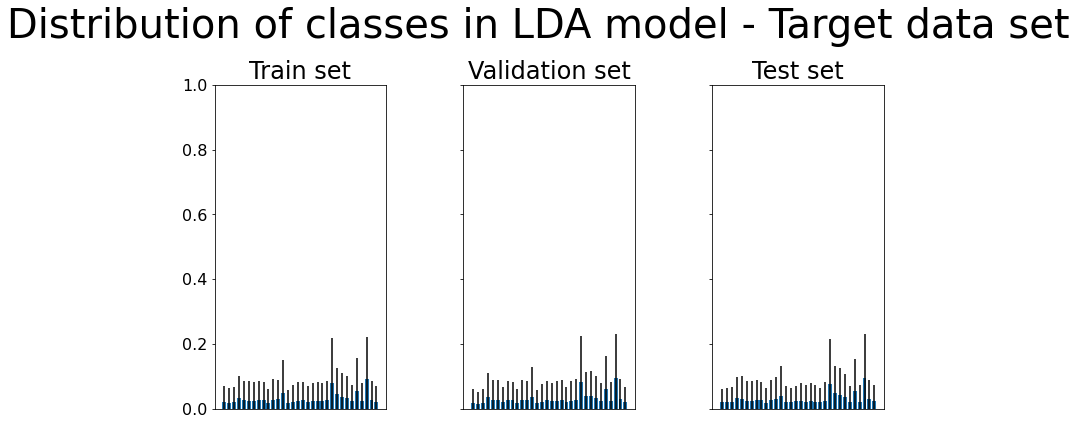

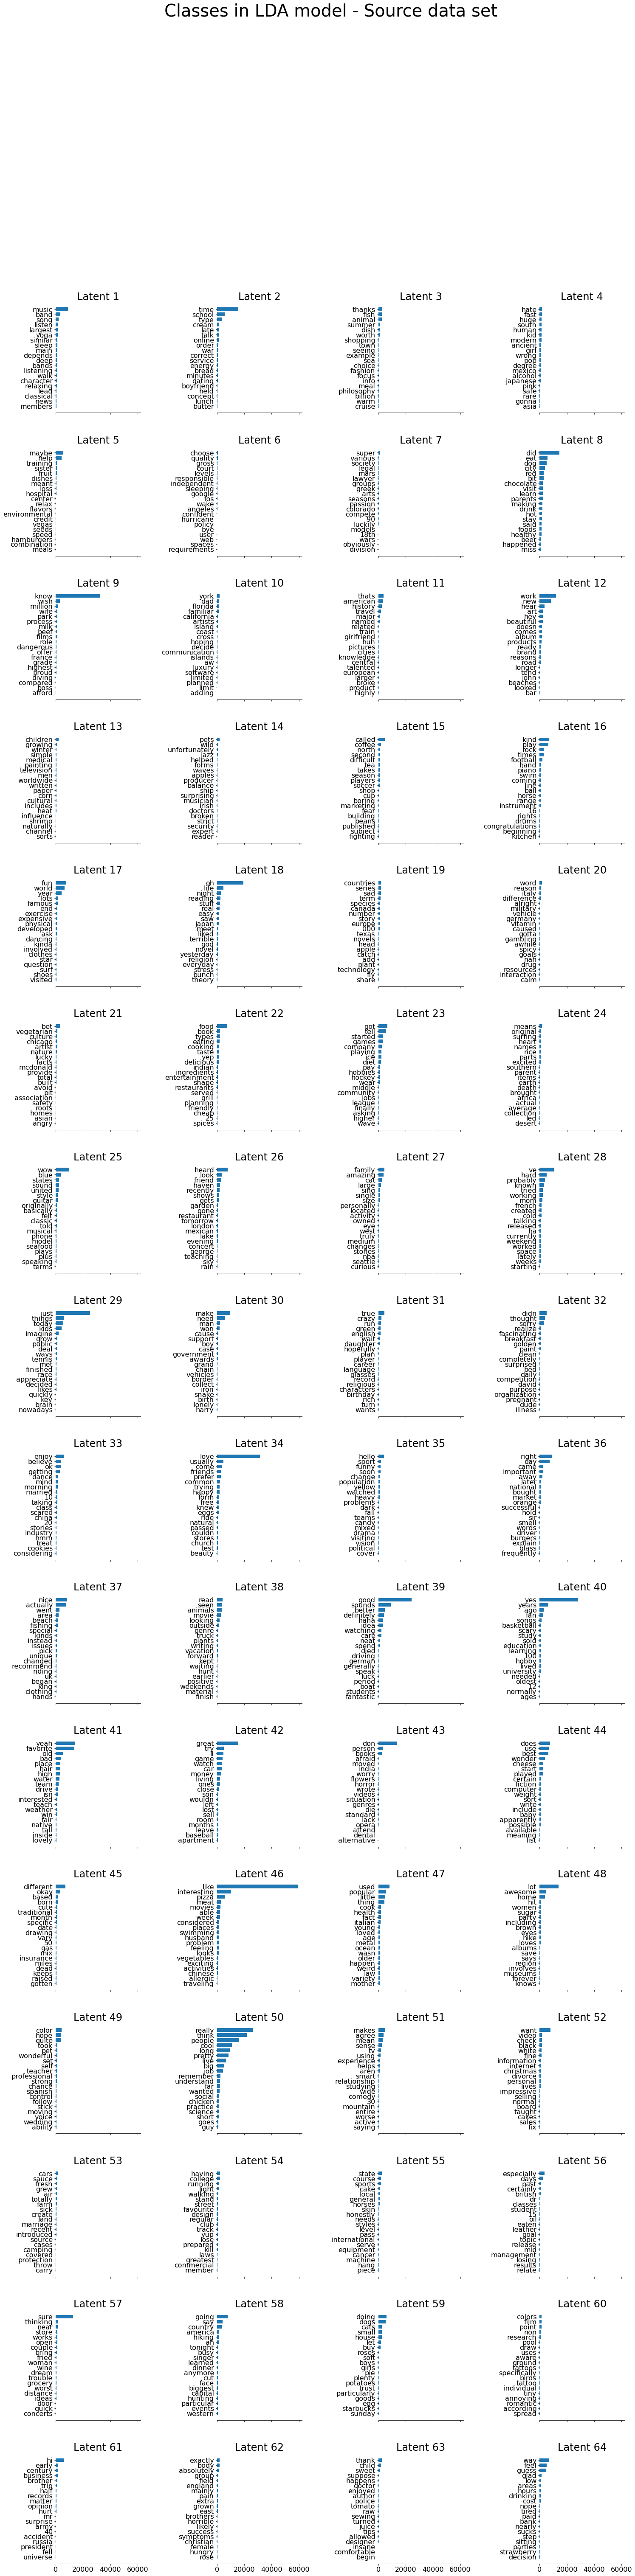

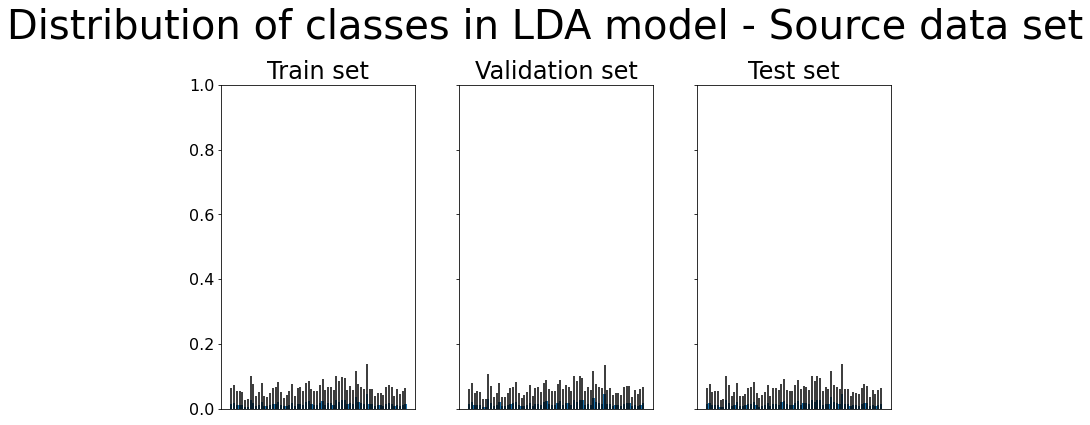

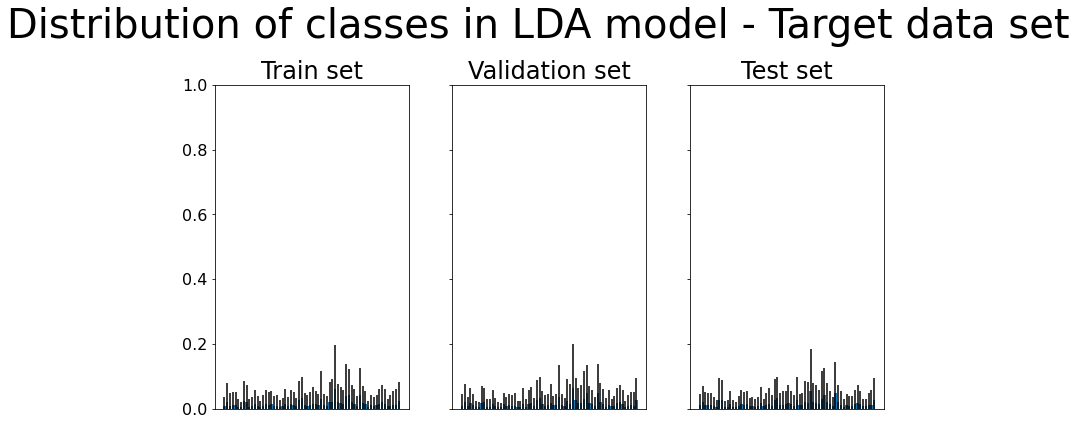

In [38]:
for n_components in n_latents:
    # Create instance
    lda = LatentDirichletAllocation(
        n_components=n_components,
        max_iter=n_iters,
        learning_method="online",
        learning_offset=learning_offset,
        random_state=random_seed,
    )
    # Fit model
    lda.fit(X_source[DataSetSplit('train')])
    # Plot results on source (pre-training) data set
    plot_top_words(lda, tf_feature_names, n_top_words, "Classes in LDA model - Source data set")
    # Plot distribution on source data set
    plot_latent_dist(lda, X_source, "Distribution of classes in LDA model - Source data set")
    # Plot distribution on target data set
    plot_latent_dist(lda, X_target, "Distribution of classes in LDA model - Target data set")

#### Interactive LDA

This is an interactive portion to play with the parameters and show the results
(it is compatible with [Google Colab](https://colab.research.google.com) interactive parameters selection).

Select parameters

In [23]:
n_components = 16  #@param {type: "slider", min: 2, max: 32}
n_iters = 5  #@param {type: "slider", min: 1, max: 10}

Run LDA

In [25]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=n_iters,
    learning_method="online",
    learning_offset=learning_offset,
    random_state=random_seed,
)
lda.fit(X_source[DataSetSplit('train')])

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=16, random_state=2307)

Show results on pre-training data sets.

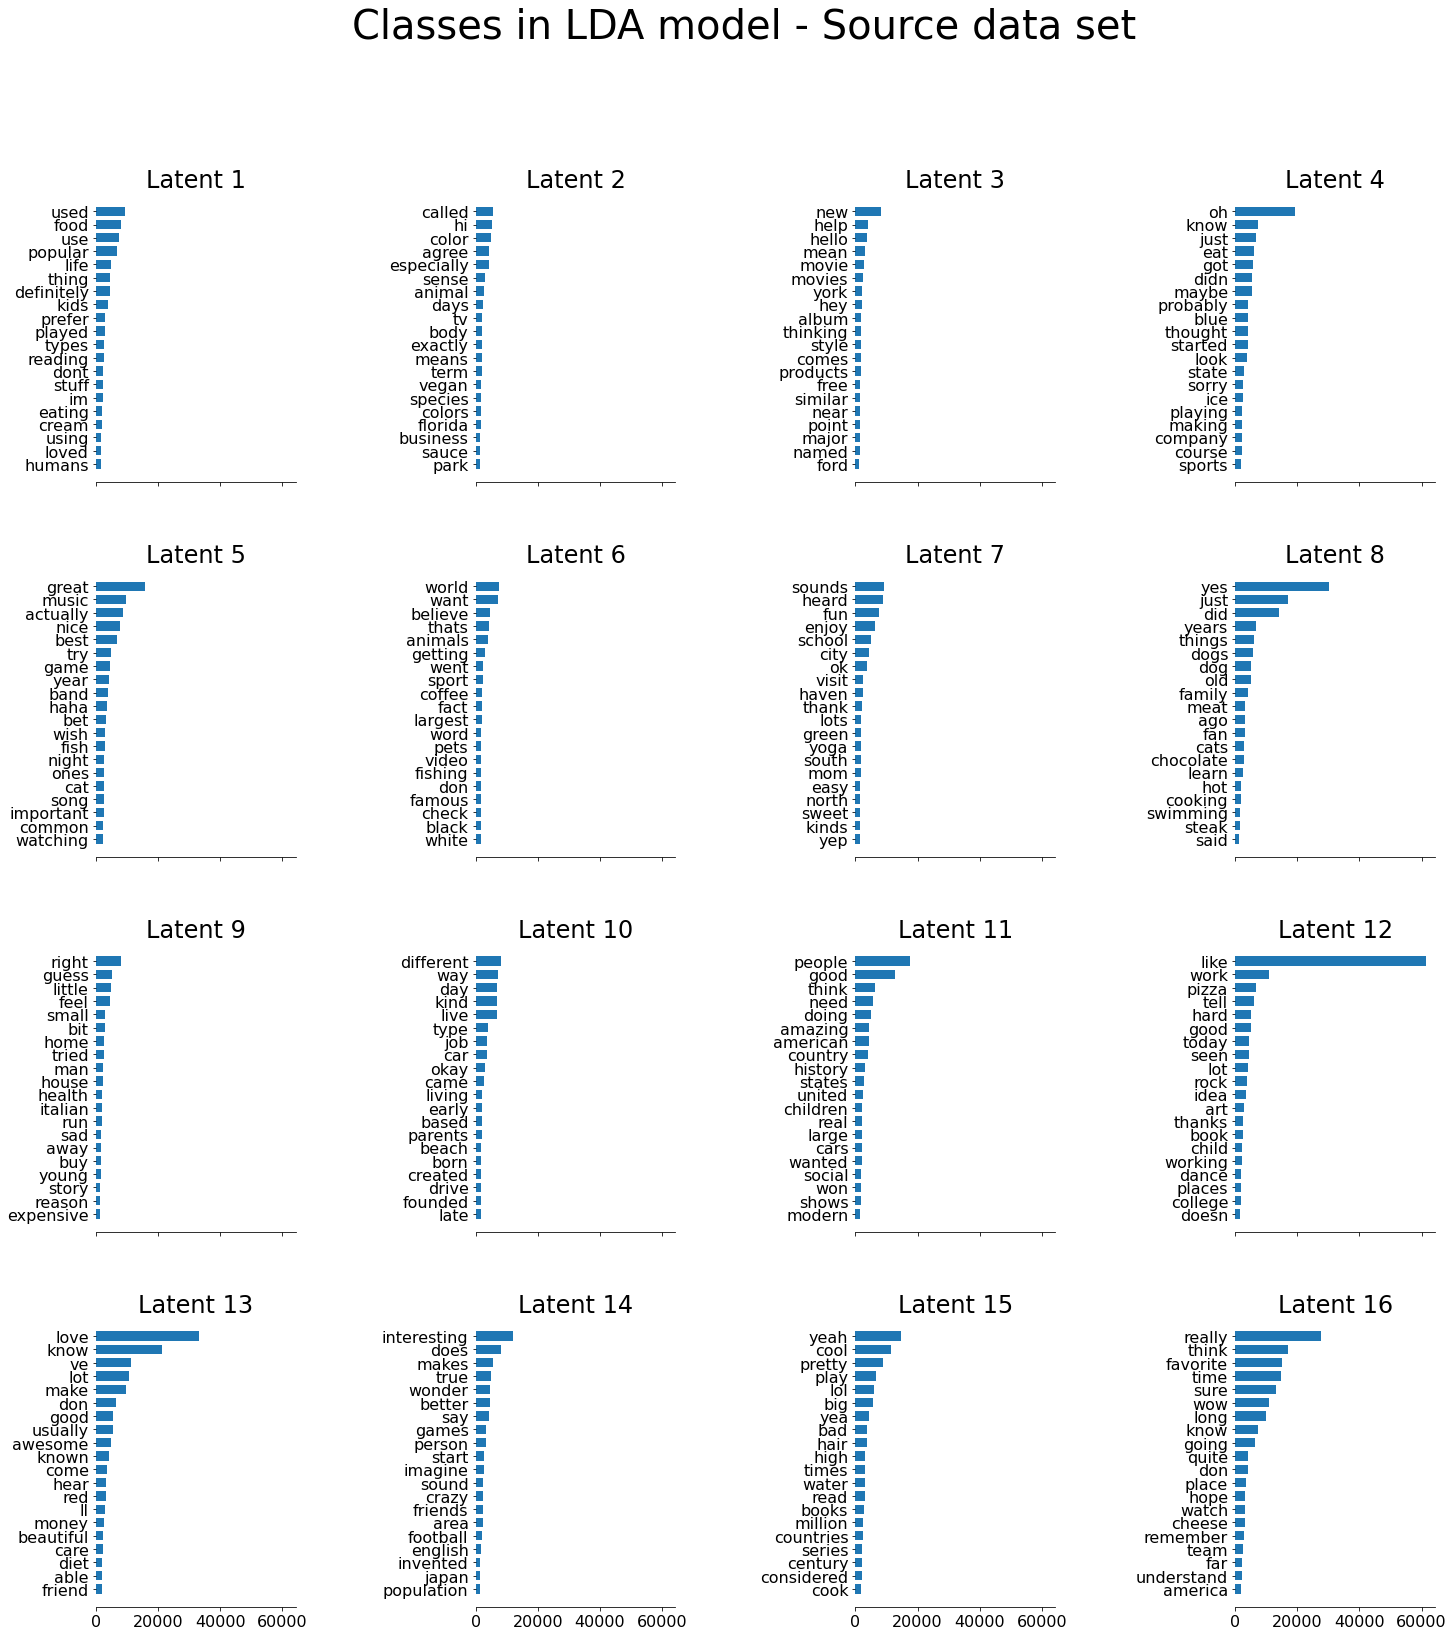

In [32]:
plot_top_words(lda, tf_feature_names, n_top_words, "Classes in LDA model - Source data set", save_figure=False, show_figure=True)

Show distribution on pre-training data set.

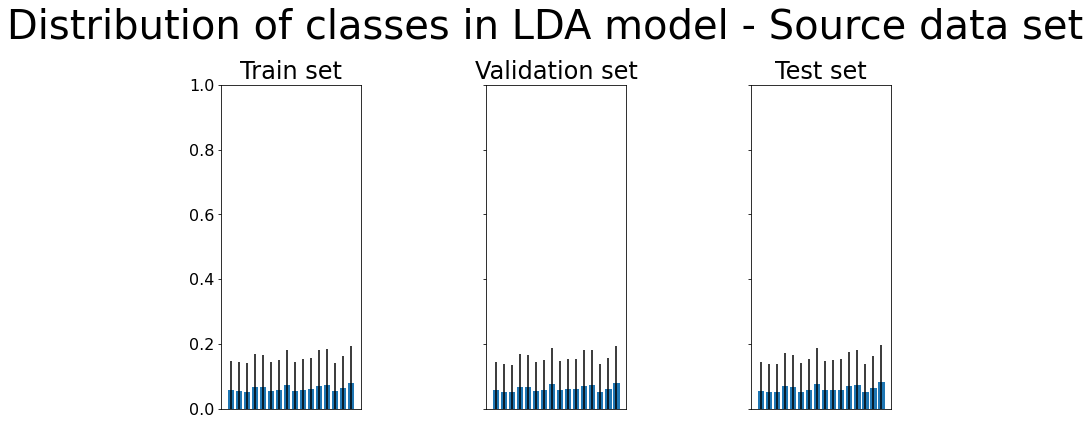

In [35]:
plot_latent_dist(lda, X_source, "Distribution of classes in LDA model - Source data set", save_figure=False, show_figure=True)

Show distribution on target data set.

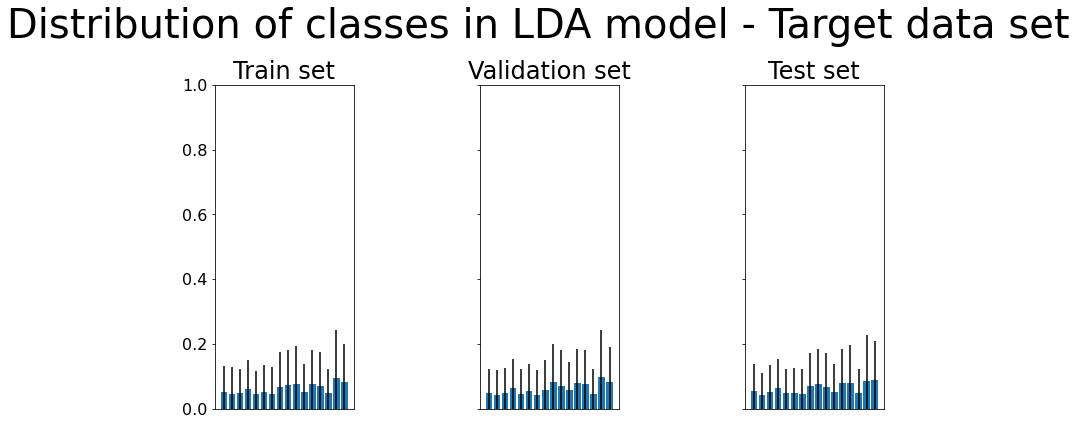

In [34]:
plot_latent_dist(lda, X_target, "Distribution of classes in LDA model - Target data set", save_figure=False, show_figure=True)